In [1]:
# dataset
from torchvision import datasets

from functools import partial
import numpy as np

# visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

# preprocessing
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torch.utils.data import random_split

# model
import torch
from torch import nn
import torchvision.models as models
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau

# hyperparameter tuning
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler

# metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# 1. Load Data & Preprocessing

**Dataset**: <a href="https://www.cs.toronto.edu/~kriz/cifar.html" target="_blank">CIFAR-10</a>

**Classes**: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck

The following transformations are tested:
* **resize**
* **center crop**
* **normalization**: from [0, 255] to [0, 1]
* **standardization**: by substracting the mean and dividing with std according to ImageNet

In [2]:
def load_data(data_dir):
    """ Create train and test pytorch dataset objects from CIFAR-10.
    
    The following tranformations are applied on CIFAR-10:
        * resize images,
        * center crop images,
        * normalization: from [0, 255] to [0, 1] by dividing with 255,
        * standardization: by substracting the mean and dividing with std according to ImageNet
    
    Args:
        data_dir:
            directory where data will be saved, as a string.
    
    Returns:
        train and test dataset, as pytorch dataset objects.
    """
    transform = transforms.Compose([
        transforms.Resize(224), 
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    trainset = datasets.CIFAR10(root=data_dir,
                                train=True, 
                                download=True, 
                                transform=transform)

    testset = datasets.CIFAR10(root=data_dir, 
                               train=False, 
                               download=True, 
                               transform=transform)

    return trainset, testset

In [3]:
trainset, testset = load_data(data_dir='cifar10-pytorch')

print(f'\nTraining data:\n--------------\n{trainset}')
print(f'Test data:\n--------------\n{testset}')

Files already downloaded and verified
Files already downloaded and verified

Training data:
--------------
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: cifar10-pytorch
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Test data:
--------------
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: cifar10-pytorch
    Split: Test
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


In [4]:
batch_size = 64

train_dataloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

# 2. VGG-16

We'll use the **pretrained version** of VGG-16. Since CIFAR-10 dataset has less classes than ImageNet, we'll keep all the layers **freezed**, except of the last one, which will be **unfreezed** and updated with the right number of classes and will be re-trained.

![VGG](images\vgg.png)

Regularization:
* Weight decay (L2 regularization)

Loss Function:
* Cross Entropy Loss

Optimizer and Scheduler:
* Adam optimizer
* ReduceLROnPlateau scheduler

In [5]:
def set_parameter_requires_grad(model, feature_extracting):
    """ This helper function sets the .requires_grad attribute of the parameters in the model 
    to False when we are feature extracting. 
    
    When we are feature extracting and only want to compute gradients for the newly initialized layer, 
    then we want all of the other parameters to not require gradients.
    
    Args:
        model: 
            deep learning model, as pytorch object.
        feature_extracting:
            whether or not we're feature extracting, as boolean.
    """
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [6]:
def initialize_model(num_labels, feature_extracting, pretrained=True):
    """ Initialize VGG-16 model and reshape the last layer with the correct number of classes.
    
    Since VGG-16 has been pretrained on Imagenet, it has output layers of size 1000, one node for each class. 
    We reshape the last layer to have the same number of inputs as before, and to have the same number of 
    outputs as the number of classes in our the dataset.
    
    Args:
        num_labels:
            number of labels in our dataset, as integer.
        feature_extracting:
          flag for feature extracting (when False, we finetune the whole model, 
          when True we only update the reshaped layer params), as boolean.
        pretrained:
            whether or not we want the pretrained version of AlexNet, as boolean.
    
    Returns:
        VGG-16 model, as pytorch object
    """
    model = models.vgg16(pretrained=pretrained)
    
    set_parameter_requires_grad(model, feature_extracting)
    
    last_layer_in_ftrs = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(last_layer_in_ftrs, num_labels)
    
    return model

# 3. Hyperparameter Tuning

We'll use **early stopping** with **ASHAScheduler** to stop bad trials earlier.

|                               | Validation Loss | Validation Accuracy |
| :---------------------------: | :-------------: | :-----------------: |
| VGG-16                        | 0.40            | 85%                 |

Best trial **configuration** for VGG-16: lr: 0.001, l2: 0.001

In [7]:
def tune_helper(config, trainset, num_labels, batch_size, epochs):
    """ Fit deep learning model and test it on a hold-out validation set.
    
    The validation set is a 20% hold-out set of the training set. 
    The loss function used is Cross Entropy Loss.
    The optimer used is Adam and the scheduler that wraps the optimizer is ReduceLROnPlateau.
    The metric used is accuracy score.
    
    Args:
        config:
            hyperparameters of neural network, as a dictionary.
        trainset:
            training dataset, as a pytorch object.
        num_labels:
            number of labels, as an integer.
        batch_size:
            size of batches to be processed, as an integer.
        epochs:
            number of epochs (times the neural network will see the data), as an integer.
    """
    feature_extracting = True
    pretrained = True
    model = initialize_model(num_labels=num_labels, 
                             feature_extracting=feature_extracting, 
                             pretrained=pretrained)
    
    # support data parallel training on multiple GPUs
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            model = nn.DataParallel(model)
    model.to(device)
    
    # create an optimizer that only updates the desired parameters
    params_to_update = model.parameters()
    print("Parameters to learn:")
    if feature_extracting:
        params_to_update = []
        for name, param in model.named_parameters():
            if param.requires_grad == True:
                params_to_update.append(param)
                print("\t", name)
    else:
        for name, param in model.named_parameters():
            if param.requires_grad == True:
                print("\t", name)
    
    # optimizer
    optimizer = AdamW(params_to_update, lr=config['lr'], weight_decay=config['l2'])
    
    #scheduler
    scheduler = ReduceLROnPlateau(optimizer, mode='min')
    
    
    # loss function
    loss_fn = nn.CrossEntropyLoss()
    
    # split data: training (80%) - validation (20%)
    test_abs = int(len(trainset) * 0.8)
    train_subset, val_subset = random_split(trainset, [test_abs, len(trainset) - test_abs])

    train_dataloader = DataLoader(train_subset,
                                  batch_size=batch_size,
                                  shuffle=True, 
                                  num_workers=2)
    
    val_dataloader = DataLoader(val_subset,
                                batch_size=batch_size,
                                shuffle=True,
                                num_workers=2)
    
    for epoch in range(epochs):
        # fit neural network on training data
        model.train()  # put on train mode
        for batch, (X, Y) in enumerate(train_dataloader, 0):
            # send the data to the GPU memory explicitly
            X, Y = X.to(device), Y.to(device)

            # reset the gradients
            optimizer.zero_grad()
            
            # compute prediction
            pred = model(X)

            # compute loss
            loss = loss_fn(pred, Y)

            # backpropagate
            loss.backward()

            # update parameters
            optimizer.step()
        
        # test on validation data
        val_loss = 0.0
        val_steps = 0
        total = 0
        correct = 0
        model.eval()  # put on evaluation mode
        for batch, (X, Y) in enumerate(val_dataloader, 0):
            with torch.no_grad():
                X, Y = X.to(device), Y.to(device)

                pred = model(X)
                
                _, predicted = torch.max(pred.data, 1)
                total += Y.size(0)
                correct += (predicted == Y).sum().item()

                loss = loss_fn(pred, Y)
                val_loss += loss.cpu().numpy()
                val_steps += 1
        
        # update scheduler
        scheduler.step(val_loss)
        
        # report metrics
        tune.report(loss=(val_loss / val_steps), accuracy=(correct / total))

In [8]:
def hyperparameter_tune(data_dir,
                        batch_size,
                        epochs,
                        config,
                        grace_period,
                        num_samples, 
                        cpus_per_trial,
                        gpus_per_trial):
    """ Run hyperparameter tuning and report best hyperparameters.
    
    Args:
        data_dir:
            directory where CIFAR-10 data will be saved/loaded, as a string.
        batch_size:
            size of batches to be processed, as an integer.
        epochs:
            number of epochs (times the neural network will see the data), as an integer.
        config:
            hyperparametes, as a dictionary.
        grace_period:
            stop trials at least this old in time, as an integer.
        num_samples:
            number of times to sample from the hyperparameter space (if grid_search is provided as an argument,
            the grid will be repeated num_samples of times), as an integer.
        cpus_per_trial:
            CPUs to allocate per trial, as integer.
        gpus_per_trial:
            GPUs to allocate per trial, as integer.
    """
    trainset, testset = load_data(data_dir=data_dir)
    
    num_labels = 10
    
    # hyperparameter search space
    cofig = config
    
    # used for early stopping
    scheduler = ASHAScheduler(metric="loss", 
                              mode="min",
                              max_t=epochs,
                              grace_period=grace_period,
                              reduction_factor=2)
    
    reporter = CLIReporter(metric_columns=["loss", "accuracy", "training_iteration"])
    
    # hyperparamet tuning
    result = tune.run(tune.with_parameters(tune_helper,
                                           trainset=trainset,
                                           num_labels=num_labels,
                                           batch_size=batch_size,
                                           epochs=epochs),
                      resources_per_trial={"cpu": cpus_per_trial, "gpu": gpus_per_trial},
                      config=config,
                      num_samples=num_samples,
                      scheduler=scheduler,
                      progress_reporter=reporter)
    
    # report best results
    best_trial = result.get_best_trial("loss", "min", "last")
    print("Best trial config: {}".format(best_trial.config))
    print("Best trial final validation loss: {}".format(best_trial.last_result["loss"]))
    print("Best trial final validation acurracy: {}".format(best_trial.last_result["accuracy"]))

In [9]:
# hyperparameter search space
config = {
    "lr": tune.grid_search([1e-3, 1e-4]),
    "l2": tune.grid_search([1e-3, 1e-4])
    }

In [10]:
hyperparameter_tune(data_dir='cifar10-pytorch',
                    batch_size=64,
                    epochs=100,
                    config=config,
                    grace_period=30,
                    num_samples=1, 
                    cpus_per_trial=0,
                    gpus_per_trial=1)

Files already downloaded and verified
Files already downloaded and verified


2021-09-07 14:03:53,582	INFO services.py:1247 -- View the Ray dashboard at http://127.0.0.1:8265
2021-09-07 14:04:06,791	WARNING function_runner.py:545 -- Function checkpointing is disabled. This may result in unexpected behavior when using checkpointing features or certain schedulers. To enable, set the train function arguments to be `func(config, checkpoint_dir=None)`.
2021-09-07 14:04:08,323	ERROR syncer.py:72 -- Log sync requires rsync to be installed.


== Status ==
Memory usage on this node: 5.8/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: None | Iter 30.000: None
Resources requested: 0/8 CPUs, 0/1 GPUs, 0.0/1.76 GiB heap, 0.0/0.88 GiB objects
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-07_14-04-06
Number of trials: 4/4 (4 PENDING)
+-------------------------+----------+-------+--------+--------+
| Trial name              | status   | loc   |     l2 |     lr |
|-------------------------+----------+-------+--------+--------|
| tune_helper_51ea1_00000 | PENDING  |       | 0.001  | 0.001  |
| tune_helper_51ea1_00001 | PENDING  |       | 0.0001 | 0.001  |
| tune_helper_51ea1_00002 | PENDING  |       | 0.001  | 0.0001 |
| tune_helper_51ea1_00003 | PENDING  |       | 0.0001 | 0.0001 |
+-------------------------+----------+-------+--------+--------+


== Status ==
Memory usage on this node: 7.0/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: None | Iter 30.000: None
Resources requested

(pid=5376) C:\Users\lampr\anaconda3\envs\cbir-dl\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
(pid=5376)   return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Result for tune_helper_51ea1_00000:
  accuracy: 0.8264
  date: 2021-09-07_14-16-44
  done: false
  experiment_id: 52f460764cdf40f597b33b29410109e0
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 1
  loss: 0.4958280626755611
  node_ip: 192.168.1.22
  pid: 5376
  time_since_restore: 754.209570646286
  time_this_iter_s: 754.209570646286
  time_total_s: 754.209570646286
  timestamp: 1631013404
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 51ea1_00000
  
== Status ==
Memory usage on this node: 6.4/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: None | Iter 30.000: None
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.76 GiB heap, 0.0/0.88 GiB objects (0.0/1.0 GPU_group_0_18c83cbef1a7fd2166078ee8821ae37a, 0.0/1.0 GPU_group_18c83cbef1a7fd2166078ee8821ae37a)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-07_14-04-06
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+-------------------------+----------+-------------------+--------+--------

Result for tune_helper_51ea1_00000:
  accuracy: 0.8433
  date: 2021-09-07_15-12-11
  done: false
  experiment_id: 52f460764cdf40f597b33b29410109e0
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 6
  loss: 0.4416514174763564
  node_ip: 192.168.1.22
  pid: 5376
  time_since_restore: 4081.3791694641113
  time_this_iter_s: 666.9658498764038
  time_total_s: 4081.3791694641113
  timestamp: 1631016731
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 51ea1_00000
  
== Status ==
Memory usage on this node: 4.7/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: None | Iter 30.000: None
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.76 GiB heap, 0.0/0.88 GiB objects (0.0/1.0 GPU_group_0_18c83cbef1a7fd2166078ee8821ae37a, 0.0/1.0 GPU_group_18c83cbef1a7fd2166078ee8821ae37a)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-07_14-04-06
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+-------------------------+----------+-------------------+--------+---

Result for tune_helper_51ea1_00000:
  accuracy: 0.8361
  date: 2021-09-07_16-06-57
  done: false
  experiment_id: 52f460764cdf40f597b33b29410109e0
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 11
  loss: 0.46174778215065126
  node_ip: 192.168.1.22
  pid: 5376
  time_since_restore: 7367.826153755188
  time_this_iter_s: 654.4851150512695
  time_total_s: 7367.826153755188
  timestamp: 1631020017
  timesteps_since_restore: 0
  training_iteration: 11
  trial_id: 51ea1_00000
  
== Status ==
Memory usage on this node: 4.8/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: None | Iter 30.000: None
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.76 GiB heap, 0.0/0.88 GiB objects (0.0/1.0 GPU_group_0_18c83cbef1a7fd2166078ee8821ae37a, 0.0/1.0 GPU_group_18c83cbef1a7fd2166078ee8821ae37a)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-07_14-04-06
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+-------------------------+----------+-------------------+--------+--

Result for tune_helper_51ea1_00000:
  accuracy: 0.8498
  date: 2021-09-07_17-01-50
  done: false
  experiment_id: 52f460764cdf40f597b33b29410109e0
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 16
  loss: 0.43427779387896226
  node_ip: 192.168.1.22
  pid: 5376
  time_since_restore: 10659.906948566437
  time_this_iter_s: 655.087952375412
  time_total_s: 10659.906948566437
  timestamp: 1631023310
  timesteps_since_restore: 0
  training_iteration: 16
  trial_id: 51ea1_00000
  
== Status ==
Memory usage on this node: 4.8/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: None | Iter 30.000: None
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.76 GiB heap, 0.0/0.88 GiB objects (0.0/1.0 GPU_group_0_18c83cbef1a7fd2166078ee8821ae37a, 0.0/1.0 GPU_group_18c83cbef1a7fd2166078ee8821ae37a)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-07_14-04-06
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+-------------------------+----------+-------------------+--------+-

Result for tune_helper_51ea1_00000:
  accuracy: 0.8449
  date: 2021-09-07_17-56-38
  done: false
  experiment_id: 52f460764cdf40f597b33b29410109e0
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 21
  loss: 0.44605851353733406
  node_ip: 192.168.1.22
  pid: 5376
  time_since_restore: 13948.591045856476
  time_this_iter_s: 654.0826964378357
  time_total_s: 13948.591045856476
  timestamp: 1631026598
  timesteps_since_restore: 0
  training_iteration: 21
  trial_id: 51ea1_00000
  
== Status ==
Memory usage on this node: 4.9/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: None | Iter 30.000: None
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.76 GiB heap, 0.0/0.88 GiB objects (0.0/1.0 GPU_group_0_18c83cbef1a7fd2166078ee8821ae37a, 0.0/1.0 GPU_group_18c83cbef1a7fd2166078ee8821ae37a)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-07_14-04-06
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+-------------------------+----------+-------------------+--------+

Result for tune_helper_51ea1_00000:
  accuracy: 0.8434
  date: 2021-09-07_18-51-17
  done: false
  experiment_id: 52f460764cdf40f597b33b29410109e0
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 26
  loss: 0.44930648680325525
  node_ip: 192.168.1.22
  pid: 5376
  time_since_restore: 17227.67206311226
  time_this_iter_s: 659.0793268680573
  time_total_s: 17227.67206311226
  timestamp: 1631029877
  timesteps_since_restore: 0
  training_iteration: 26
  trial_id: 51ea1_00000
  
== Status ==
Memory usage on this node: 5.0/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: None | Iter 30.000: None
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.76 GiB heap, 0.0/0.88 GiB objects (0.0/1.0 GPU_group_0_18c83cbef1a7fd2166078ee8821ae37a, 0.0/1.0 GPU_group_18c83cbef1a7fd2166078ee8821ae37a)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-07_14-04-06
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+-------------------------+----------+-------------------+--------+--

Result for tune_helper_51ea1_00000:
  accuracy: 0.8475
  date: 2021-09-07_19-45-52
  done: false
  experiment_id: 52f460764cdf40f597b33b29410109e0
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 31
  loss: 0.4392168277957637
  node_ip: 192.168.1.22
  pid: 5376
  time_since_restore: 20502.719297647476
  time_this_iter_s: 653.9517302513123
  time_total_s: 20502.719297647476
  timestamp: 1631033152
  timesteps_since_restore: 0
  training_iteration: 31
  trial_id: 51ea1_00000
  
== Status ==
Memory usage on this node: 4.9/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: None | Iter 30.000: -0.4386424579817778
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.76 GiB heap, 0.0/0.88 GiB objects (0.0/1.0 GPU_group_0_18c83cbef1a7fd2166078ee8821ae37a, 0.0/1.0 GPU_group_18c83cbef1a7fd2166078ee8821ae37a)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-07_14-04-06
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+-------------------------+----------+---------------

Result for tune_helper_51ea1_00000:
  accuracy: 0.8566
  date: 2021-09-07_20-40-46
  done: false
  experiment_id: 52f460764cdf40f597b33b29410109e0
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 36
  loss: 0.4174450014237386
  node_ip: 192.168.1.22
  pid: 5376
  time_since_restore: 23796.36136817932
  time_this_iter_s: 656.2096073627472
  time_total_s: 23796.36136817932
  timestamp: 1631036446
  timesteps_since_restore: 0
  training_iteration: 36
  trial_id: 51ea1_00000
  
== Status ==
Memory usage on this node: 5.0/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: None | Iter 30.000: -0.4386424579817778
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.76 GiB heap, 0.0/0.88 GiB objects (0.0/1.0 GPU_group_0_18c83cbef1a7fd2166078ee8821ae37a, 0.0/1.0 GPU_group_18c83cbef1a7fd2166078ee8821ae37a)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-07_14-04-06
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+-------------------------+----------+-----------------

Result for tune_helper_51ea1_00000:
  accuracy: 0.8574
  date: 2021-09-07_21-35-31
  done: false
  experiment_id: 52f460764cdf40f597b33b29410109e0
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 41
  loss: 0.40796412641455415
  node_ip: 192.168.1.22
  pid: 5376
  time_since_restore: 27081.2086455822
  time_this_iter_s: 654.3216137886047
  time_total_s: 27081.2086455822
  timestamp: 1631039731
  timesteps_since_restore: 0
  training_iteration: 41
  trial_id: 51ea1_00000
  
== Status ==
Memory usage on this node: 4.9/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: None | Iter 30.000: -0.4386424579817778
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.76 GiB heap, 0.0/0.88 GiB objects (0.0/1.0 GPU_group_0_18c83cbef1a7fd2166078ee8821ae37a, 0.0/1.0 GPU_group_18c83cbef1a7fd2166078ee8821ae37a)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-07_14-04-06
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+-------------------------+----------+------------------

Result for tune_helper_51ea1_00000:
  accuracy: 0.8571
  date: 2021-09-07_22-30-10
  done: false
  experiment_id: 52f460764cdf40f597b33b29410109e0
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 46
  loss: 0.40507873256874694
  node_ip: 192.168.1.22
  pid: 5376
  time_since_restore: 30360.495829105377
  time_this_iter_s: 655.721777677536
  time_total_s: 30360.495829105377
  timestamp: 1631043010
  timesteps_since_restore: 0
  training_iteration: 46
  trial_id: 51ea1_00000
  
== Status ==
Memory usage on this node: 5.0/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: None | Iter 30.000: -0.4386424579817778
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.76 GiB heap, 0.0/0.88 GiB objects (0.0/1.0 GPU_group_0_18c83cbef1a7fd2166078ee8821ae37a, 0.0/1.0 GPU_group_18c83cbef1a7fd2166078ee8821ae37a)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-07_14-04-06
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+-------------------------+----------+---------------

Result for tune_helper_51ea1_00000:
  accuracy: 0.8575
  date: 2021-09-07_23-25-13
  done: false
  experiment_id: 52f460764cdf40f597b33b29410109e0
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 51
  loss: 0.40326162014797234
  node_ip: 192.168.1.22
  pid: 5376
  time_since_restore: 33663.36974787712
  time_this_iter_s: 662.3947114944458
  time_total_s: 33663.36974787712
  timestamp: 1631046313
  timesteps_since_restore: 0
  training_iteration: 51
  trial_id: 51ea1_00000
  
== Status ==
Memory usage on this node: 5.0/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: None | Iter 30.000: -0.4386424579817778
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.76 GiB heap, 0.0/0.88 GiB objects (0.0/1.0 GPU_group_0_18c83cbef1a7fd2166078ee8821ae37a, 0.0/1.0 GPU_group_18c83cbef1a7fd2166078ee8821ae37a)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-07_14-04-06
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+-------------------------+----------+----------------

Result for tune_helper_51ea1_00000:
  accuracy: 0.8562
  date: 2021-09-08_00-20-47
  done: false
  experiment_id: 52f460764cdf40f597b33b29410109e0
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 56
  loss: 0.4037783863438163
  node_ip: 192.168.1.22
  pid: 5376
  time_since_restore: 36997.06295800209
  time_this_iter_s: 662.9050421714783
  time_total_s: 36997.06295800209
  timestamp: 1631049647
  timesteps_since_restore: 0
  training_iteration: 56
  trial_id: 51ea1_00000
  
== Status ==
Memory usage on this node: 5.0/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: None | Iter 30.000: -0.4386424579817778
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.76 GiB heap, 0.0/0.88 GiB objects (0.0/1.0 GPU_group_0_18c83cbef1a7fd2166078ee8821ae37a, 0.0/1.0 GPU_group_18c83cbef1a7fd2166078ee8821ae37a)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-07_14-04-06
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+-------------------------+----------+-----------------

Result for tune_helper_51ea1_00000:
  accuracy: 0.8576
  date: 2021-09-08_01-16-07
  done: false
  experiment_id: 52f460764cdf40f597b33b29410109e0
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 61
  loss: 0.40360531856299964
  node_ip: 192.168.1.22
  pid: 5376
  time_since_restore: 40317.51040458679
  time_this_iter_s: 670.334311246872
  time_total_s: 40317.51040458679
  timestamp: 1631052967
  timesteps_since_restore: 0
  training_iteration: 61
  trial_id: 51ea1_00000
  
== Status ==
Memory usage on this node: 5.1/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: -0.40230979642290976 | Iter 30.000: -0.4386424579817778
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.76 GiB heap, 0.0/0.88 GiB objects (0.0/1.0 GPU_group_0_18c83cbef1a7fd2166078ee8821ae37a, 0.0/1.0 GPU_group_18c83cbef1a7fd2166078ee8821ae37a)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-07_14-04-06
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+-------------------------+----------+-

Result for tune_helper_51ea1_00000:
  accuracy: 0.8562
  date: 2021-09-08_02-11-42
  done: false
  experiment_id: 52f460764cdf40f597b33b29410109e0
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 66
  loss: 0.40316668257212185
  node_ip: 192.168.1.22
  pid: 5376
  time_since_restore: 43652.251697301865
  time_this_iter_s: 674.240549325943
  time_total_s: 43652.251697301865
  timestamp: 1631056302
  timesteps_since_restore: 0
  training_iteration: 66
  trial_id: 51ea1_00000
  
== Status ==
Memory usage on this node: 5.1/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: -0.40230979642290976 | Iter 30.000: -0.4386424579817778
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.76 GiB heap, 0.0/0.88 GiB objects (0.0/1.0 GPU_group_0_18c83cbef1a7fd2166078ee8821ae37a, 0.0/1.0 GPU_group_18c83cbef1a7fd2166078ee8821ae37a)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-07_14-04-06
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+-------------------------+----------

Result for tune_helper_51ea1_00000:
  accuracy: 0.8571
  date: 2021-09-08_03-07-08
  done: false
  experiment_id: 52f460764cdf40f597b33b29410109e0
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 71
  loss: 0.403330174695914
  node_ip: 192.168.1.22
  pid: 5376
  time_since_restore: 46978.87209057808
  time_this_iter_s: 662.1316118240356
  time_total_s: 46978.87209057808
  timestamp: 1631059628
  timesteps_since_restore: 0
  training_iteration: 71
  trial_id: 51ea1_00000
  
== Status ==
Memory usage on this node: 5.1/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: -0.40230979642290976 | Iter 30.000: -0.4386424579817778
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.76 GiB heap, 0.0/0.88 GiB objects (0.0/1.0 GPU_group_0_18c83cbef1a7fd2166078ee8821ae37a, 0.0/1.0 GPU_group_18c83cbef1a7fd2166078ee8821ae37a)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-07_14-04-06
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+-------------------------+----------+--

Result for tune_helper_51ea1_00000:
  accuracy: 0.8573
  date: 2021-09-08_04-02-47
  done: false
  experiment_id: 52f460764cdf40f597b33b29410109e0
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 76
  loss: 0.40318209872503946
  node_ip: 192.168.1.22
  pid: 5376
  time_since_restore: 50317.339077711105
  time_this_iter_s: 669.9860439300537
  time_total_s: 50317.339077711105
  timestamp: 1631062967
  timesteps_since_restore: 0
  training_iteration: 76
  trial_id: 51ea1_00000
  
== Status ==
Memory usage on this node: 5.1/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: -0.40230979642290976 | Iter 30.000: -0.4386424579817778
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.76 GiB heap, 0.0/0.88 GiB objects (0.0/1.0 GPU_group_0_18c83cbef1a7fd2166078ee8821ae37a, 0.0/1.0 GPU_group_18c83cbef1a7fd2166078ee8821ae37a)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-07_14-04-06
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+-------------------------+---------

Result for tune_helper_51ea1_00000:
  accuracy: 0.8574
  date: 2021-09-08_04-58-42
  done: false
  experiment_id: 52f460764cdf40f597b33b29410109e0
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 81
  loss: 0.402071430235152
  node_ip: 192.168.1.22
  pid: 5376
  time_since_restore: 53672.3722345829
  time_this_iter_s: 678.4466691017151
  time_total_s: 53672.3722345829
  timestamp: 1631066322
  timesteps_since_restore: 0
  training_iteration: 81
  trial_id: 51ea1_00000
  
== Status ==
Memory usage on this node: 5.1/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: -0.40230979642290976 | Iter 30.000: -0.4386424579817778
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.76 GiB heap, 0.0/0.88 GiB objects (0.0/1.0 GPU_group_0_18c83cbef1a7fd2166078ee8821ae37a, 0.0/1.0 GPU_group_18c83cbef1a7fd2166078ee8821ae37a)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-07_14-04-06
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+-------------------------+----------+----

Result for tune_helper_51ea1_00000:
  accuracy: 0.8581
  date: 2021-09-08_05-54-16
  done: false
  experiment_id: 52f460764cdf40f597b33b29410109e0
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 86
  loss: 0.4027191876036346
  node_ip: 192.168.1.22
  pid: 5376
  time_since_restore: 57006.686227321625
  time_this_iter_s: 672.9643743038177
  time_total_s: 57006.686227321625
  timestamp: 1631069656
  timesteps_since_restore: 0
  training_iteration: 86
  trial_id: 51ea1_00000
  
== Status ==
Memory usage on this node: 5.3/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: -0.40230979642290976 | Iter 30.000: -0.4386424579817778
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.76 GiB heap, 0.0/0.88 GiB objects (0.0/1.0 GPU_group_0_18c83cbef1a7fd2166078ee8821ae37a, 0.0/1.0 GPU_group_18c83cbef1a7fd2166078ee8821ae37a)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-07_14-04-06
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+-------------------------+----------

Result for tune_helper_51ea1_00000:
  accuracy: 0.8575
  date: 2021-09-08_06-49-30
  done: false
  experiment_id: 52f460764cdf40f597b33b29410109e0
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 91
  loss: 0.40217617049718357
  node_ip: 192.168.1.22
  pid: 5376
  time_since_restore: 60320.65897941589
  time_this_iter_s: 662.4553272724152
  time_total_s: 60320.65897941589
  timestamp: 1631072970
  timesteps_since_restore: 0
  training_iteration: 91
  trial_id: 51ea1_00000
  
== Status ==
Memory usage on this node: 5.2/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: -0.40230979642290976 | Iter 30.000: -0.4386424579817778
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.76 GiB heap, 0.0/0.88 GiB objects (0.0/1.0 GPU_group_0_18c83cbef1a7fd2166078ee8821ae37a, 0.0/1.0 GPU_group_18c83cbef1a7fd2166078ee8821ae37a)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-07_14-04-06
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+-------------------------+----------+

Result for tune_helper_51ea1_00000:
  accuracy: 0.8576
  date: 2021-09-08_07-44-53
  done: false
  experiment_id: 52f460764cdf40f597b33b29410109e0
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 96
  loss: 0.40375645843091285
  node_ip: 192.168.1.22
  pid: 5376
  time_since_restore: 63643.77393364906
  time_this_iter_s: 662.1336324214935
  time_total_s: 63643.77393364906
  timestamp: 1631076293
  timesteps_since_restore: 0
  training_iteration: 96
  trial_id: 51ea1_00000
  
== Status ==
Memory usage on this node: 5.1/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: -0.40230979642290976 | Iter 30.000: -0.4386424579817778
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.76 GiB heap, 0.0/0.88 GiB objects (0.0/1.0 GPU_group_0_18c83cbef1a7fd2166078ee8821ae37a, 0.0/1.0 GPU_group_18c83cbef1a7fd2166078ee8821ae37a)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-07_14-04-06
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+-------------------------+----------+

== Status ==
Memory usage on this node: 5.2/7.9 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 60.000: -0.40230979642290976 | Iter 30.000: -0.4386424579817778
Resources requested: 0/8 CPUs, 0/1 GPUs, 0.0/1.76 GiB heap, 0.0/0.88 GiB objects (0.0/1.0 GPU_group_0_18c83cbef1a7fd2166078ee8821ae37a, 0.0/1.0 GPU_group_18c83cbef1a7fd2166078ee8821ae37a)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-07_14-04-06
Number of trials: 4/4 (3 PENDING, 1 TERMINATED)
+-------------------------+------------+-------+--------+--------+----------+------------+----------------------+
| Trial name              | status     | loc   |     l2 |     lr |     loss |   accuracy |   training_iteration |
|-------------------------+------------+-------+--------+--------+----------+------------+----------------------|
| tune_helper_51ea1_00001 | PENDING    |       | 0.0001 | 0.001  |          |            |                      |
| tune_helper_51ea1_00002 | PENDING    |       | 0.001  | 0.0001 |  

(pid=5376) Windows fatal exception: access violation
(pid=5376) 


(pid=5576) Parameters to learn:
(pid=5576) 	 classifier.6.weight
(pid=5576) 	 classifier.6.bias


(pid=5576) C:\Users\lampr\anaconda3\envs\cbir-dl\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
(pid=5576)   return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Result for tune_helper_51ea1_00001:
  accuracy: 0.8329
  date: 2021-09-08_08-41-33
  done: false
  experiment_id: c2358a882600444d9b5709a102c35d15
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 1
  loss: 0.47513328502132635
  node_ip: 192.168.1.22
  pid: 5576
  time_since_restore: 722.5507683753967
  time_this_iter_s: 722.5507683753967
  time_total_s: 722.5507683753967
  timestamp: 1631079693
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 51ea1_00001
  
== Status ==
Memory usage on this node: 6.4/7.9 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 60.000: -0.40230979642290976 | Iter 30.000: -0.4386424579817778
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.76 GiB heap, 0.0/0.88 GiB objects (0.0/1.0 GPU_group_0_18c83cbef1a7fd2166078ee8821ae37a, 0.0/1.0 GPU_group_18c83cbef1a7fd2166078ee8821ae37a)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-07_14-04-06
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+-------------------------

Result for tune_helper_51ea1_00001:
  accuracy: 0.8377
  date: 2021-09-08_09-37-28
  done: false
  experiment_id: c2358a882600444d9b5709a102c35d15
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 6
  loss: 0.4596694753428174
  node_ip: 192.168.1.22
  pid: 5576
  time_since_restore: 4078.101062297821
  time_this_iter_s: 663.0735921859741
  time_total_s: 4078.101062297821
  timestamp: 1631083048
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 51ea1_00001
  
== Status ==
Memory usage on this node: 6.3/7.9 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 60.000: -0.40230979642290976 | Iter 30.000: -0.4386424579817778
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.76 GiB heap, 0.0/0.88 GiB objects (0.0/1.0 GPU_group_0_18c83cbef1a7fd2166078ee8821ae37a, 0.0/1.0 GPU_group_18c83cbef1a7fd2166078ee8821ae37a)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-07_14-04-06
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+-------------------------+

Result for tune_helper_51ea1_00001:
  accuracy: 0.8456
  date: 2021-09-08_10-32-37
  done: false
  experiment_id: c2358a882600444d9b5709a102c35d15
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 11
  loss: 0.44028733651729146
  node_ip: 192.168.1.22
  pid: 5576
  time_since_restore: 7386.889456033707
  time_this_iter_s: 655.7668790817261
  time_total_s: 7386.889456033707
  timestamp: 1631086357
  timesteps_since_restore: 0
  training_iteration: 11
  trial_id: 51ea1_00001
  
== Status ==
Memory usage on this node: 6.1/7.9 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 60.000: -0.40230979642290976 | Iter 30.000: -0.4386424579817778
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.76 GiB heap, 0.0/0.88 GiB objects (0.0/1.0 GPU_group_0_18c83cbef1a7fd2166078ee8821ae37a, 0.0/1.0 GPU_group_18c83cbef1a7fd2166078ee8821ae37a)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-07_14-04-06
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+-----------------------

Result for tune_helper_51ea1_00001:
  accuracy: 0.8465
  date: 2021-09-08_11-27-39
  done: false
  experiment_id: c2358a882600444d9b5709a102c35d15
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 16
  loss: 0.43726923463830525
  node_ip: 192.168.1.22
  pid: 5576
  time_since_restore: 10688.709149837494
  time_this_iter_s: 658.6559164524078
  time_total_s: 10688.709149837494
  timestamp: 1631089659
  timesteps_since_restore: 0
  training_iteration: 16
  trial_id: 51ea1_00001
  
== Status ==
Memory usage on this node: 5.7/7.9 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 60.000: -0.40230979642290976 | Iter 30.000: -0.4386424579817778
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.76 GiB heap, 0.0/0.88 GiB objects (0.0/1.0 GPU_group_0_18c83cbef1a7fd2166078ee8821ae37a, 0.0/1.0 GPU_group_18c83cbef1a7fd2166078ee8821ae37a)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-07_14-04-06
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+---------------------

Result for tune_helper_51ea1_00001:
  accuracy: 0.8444
  date: 2021-09-08_12-22-48
  done: false
  experiment_id: c2358a882600444d9b5709a102c35d15
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 21
  loss: 0.4480362239347142
  node_ip: 192.168.1.22
  pid: 5576
  time_since_restore: 13998.032882928848
  time_this_iter_s: 660.4351360797882
  time_total_s: 13998.032882928848
  timestamp: 1631092968
  timesteps_since_restore: 0
  training_iteration: 21
  trial_id: 51ea1_00001
  
== Status ==
Memory usage on this node: 5.8/7.9 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 60.000: -0.40230979642290976 | Iter 30.000: -0.4386424579817778
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.76 GiB heap, 0.0/0.88 GiB objects (0.0/1.0 GPU_group_0_18c83cbef1a7fd2166078ee8821ae37a, 0.0/1.0 GPU_group_18c83cbef1a7fd2166078ee8821ae37a)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-07_14-04-06
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+----------------------

Result for tune_helper_51ea1_00001:
  accuracy: 0.8487
  date: 2021-09-08_13-17-37
  done: false
  experiment_id: c2358a882600444d9b5709a102c35d15
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 26
  loss: 0.4386380867688519
  node_ip: 192.168.1.22
  pid: 5576
  time_since_restore: 17286.956430196762
  time_this_iter_s: 657.7620813846588
  time_total_s: 17286.956430196762
  timestamp: 1631096257
  timesteps_since_restore: 0
  training_iteration: 26
  trial_id: 51ea1_00001
  
== Status ==
Memory usage on this node: 5.5/7.9 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 60.000: -0.40230979642290976 | Iter 30.000: -0.4386424579817778
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.76 GiB heap, 0.0/0.88 GiB objects (0.0/1.0 GPU_group_0_18c83cbef1a7fd2166078ee8821ae37a, 0.0/1.0 GPU_group_18c83cbef1a7fd2166078ee8821ae37a)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-07_14-04-06
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+----------------------

== Status ==
Memory usage on this node: 5.6/7.9 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 60.000: -0.40230979642290976 | Iter 30.000: -0.43989512053834406
Resources requested: 0/8 CPUs, 0/1 GPUs, 0.0/1.76 GiB heap, 0.0/0.88 GiB objects (0.0/1.0 GPU_group_0_18c83cbef1a7fd2166078ee8821ae37a, 0.0/1.0 GPU_group_18c83cbef1a7fd2166078ee8821ae37a)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-07_14-04-06
Number of trials: 4/4 (2 PENDING, 2 TERMINATED)
+-------------------------+------------+-------+--------+--------+----------+------------+----------------------+
| Trial name              | status     | loc   |     l2 |     lr |     loss |   accuracy |   training_iteration |
|-------------------------+------------+-------+--------+--------+----------+------------+----------------------|
| tune_helper_51ea1_00002 | PENDING    |       | 0.001  | 0.0001 |          |            |                      |
| tune_helper_51ea1_00003 | PENDING    |       | 0.0001 | 0.0001 | 

(pid=5576) Windows fatal exception: access violation
(pid=5576) 


(pid=7008) Parameters to learn:
(pid=7008) 	 classifier.6.weight
(pid=7008) 	 classifier.6.bias


(pid=7008) C:\Users\lampr\anaconda3\envs\cbir-dl\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
(pid=7008)   return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Result for tune_helper_51ea1_00002:
  accuracy: 0.8001
  date: 2021-09-08_14-13-22
  done: false
  experiment_id: d85fa6c8a88c4257beaab05ca8aaf7a3
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 1
  loss: 0.649389040508088
  node_ip: 192.168.1.22
  pid: 7008
  time_since_restore: 695.0302665233612
  time_this_iter_s: 695.0302665233612
  time_total_s: 695.0302665233612
  timestamp: 1631099602
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 51ea1_00002
  
== Status ==
Memory usage on this node: 6.4/7.9 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 60.000: -0.40230979642290976 | Iter 30.000: -0.43989512053834406
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.76 GiB heap, 0.0/0.88 GiB objects (0.0/1.0 GPU_group_0_18c83cbef1a7fd2166078ee8821ae37a, 0.0/1.0 GPU_group_18c83cbef1a7fd2166078ee8821ae37a)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-07_14-04-06
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+-------------------------+

Result for tune_helper_51ea1_00002:
  accuracy: 0.8357
  date: 2021-09-08_15-08-13
  done: false
  experiment_id: d85fa6c8a88c4257beaab05ca8aaf7a3
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 6
  loss: 0.48998479839343173
  node_ip: 192.168.1.22
  pid: 7008
  time_since_restore: 3985.8775742053986
  time_this_iter_s: 655.2542681694031
  time_total_s: 3985.8775742053986
  timestamp: 1631102893
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 51ea1_00002
  
== Status ==
Memory usage on this node: 5.3/7.9 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 60.000: -0.40230979642290976 | Iter 30.000: -0.43989512053834406
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.76 GiB heap, 0.0/0.88 GiB objects (0.0/1.0 GPU_group_0_18c83cbef1a7fd2166078ee8821ae37a, 0.0/1.0 GPU_group_18c83cbef1a7fd2166078ee8821ae37a)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-07_14-04-06
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+----------------------

Result for tune_helper_51ea1_00002:
  accuracy: 0.8449
  date: 2021-09-08_16-03-04
  done: false
  experiment_id: d85fa6c8a88c4257beaab05ca8aaf7a3
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 11
  loss: 0.4582826718213452
  node_ip: 192.168.1.22
  pid: 7008
  time_since_restore: 7276.858106136322
  time_this_iter_s: 653.062680721283
  time_total_s: 7276.858106136322
  timestamp: 1631106184
  timesteps_since_restore: 0
  training_iteration: 11
  trial_id: 51ea1_00002
  
== Status ==
Memory usage on this node: 5.3/7.9 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 60.000: -0.40230979642290976 | Iter 30.000: -0.43989512053834406
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.76 GiB heap, 0.0/0.88 GiB objects (0.0/1.0 GPU_group_0_18c83cbef1a7fd2166078ee8821ae37a, 0.0/1.0 GPU_group_18c83cbef1a7fd2166078ee8821ae37a)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-07_14-04-06
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------

Result for tune_helper_51ea1_00002:
  accuracy: 0.848
  date: 2021-09-08_16-57-45
  done: false
  experiment_id: d85fa6c8a88c4257beaab05ca8aaf7a3
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 16
  loss: 0.4467804282903671
  node_ip: 192.168.1.22
  pid: 7008
  time_since_restore: 10557.944823503494
  time_this_iter_s: 667.2109251022339
  time_total_s: 10557.944823503494
  timestamp: 1631109465
  timesteps_since_restore: 0
  training_iteration: 16
  trial_id: 51ea1_00002
  
== Status ==
Memory usage on this node: 5.3/7.9 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 60.000: -0.40230979642290976 | Iter 30.000: -0.43989512053834406
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.76 GiB heap, 0.0/0.88 GiB objects (0.0/1.0 GPU_group_0_18c83cbef1a7fd2166078ee8821ae37a, 0.0/1.0 GPU_group_18c83cbef1a7fd2166078ee8821ae37a)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-07_14-04-06
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+----------------------

Result for tune_helper_51ea1_00002:
  accuracy: 0.8475
  date: 2021-09-08_17-52-29
  done: false
  experiment_id: d85fa6c8a88c4257beaab05ca8aaf7a3
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 21
  loss: 0.4429696673990055
  node_ip: 192.168.1.22
  pid: 7008
  time_since_restore: 13841.206355333328
  time_this_iter_s: 654.3924837112427
  time_total_s: 13841.206355333328
  timestamp: 1631112749
  timesteps_since_restore: 0
  training_iteration: 21
  trial_id: 51ea1_00002
  
== Status ==
Memory usage on this node: 5.4/7.9 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 60.000: -0.40230979642290976 | Iter 30.000: -0.43989512053834406
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.76 GiB heap, 0.0/0.88 GiB objects (0.0/1.0 GPU_group_0_18c83cbef1a7fd2166078ee8821ae37a, 0.0/1.0 GPU_group_18c83cbef1a7fd2166078ee8821ae37a)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-07_14-04-06
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+---------------------

Result for tune_helper_51ea1_00002:
  accuracy: 0.8519
  date: 2021-09-08_18-47-15
  done: false
  experiment_id: d85fa6c8a88c4257beaab05ca8aaf7a3
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 26
  loss: 0.43602986244639014
  node_ip: 192.168.1.22
  pid: 7008
  time_since_restore: 17127.444373846054
  time_this_iter_s: 659.2919204235077
  time_total_s: 17127.444373846054
  timestamp: 1631116035
  timesteps_since_restore: 0
  training_iteration: 26
  trial_id: 51ea1_00002
  
== Status ==
Memory usage on this node: 5.3/7.9 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 60.000: -0.40230979642290976 | Iter 30.000: -0.43989512053834406
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.76 GiB heap, 0.0/0.88 GiB objects (0.0/1.0 GPU_group_0_18c83cbef1a7fd2166078ee8821ae37a, 0.0/1.0 GPU_group_18c83cbef1a7fd2166078ee8821ae37a)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-07_14-04-06
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+--------------------

Result for tune_helper_51ea1_00002:
  accuracy: 0.8519
  date: 2021-09-08_19-42-47
  done: false
  experiment_id: d85fa6c8a88c4257beaab05ca8aaf7a3
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 31
  loss: 0.43228085804137456
  node_ip: 192.168.1.22
  pid: 7008
  time_since_restore: 20459.606384515762
  time_this_iter_s: 652.3107845783234
  time_total_s: 20459.606384515762
  timestamp: 1631119367
  timesteps_since_restore: 0
  training_iteration: 31
  trial_id: 51ea1_00002
  
== Status ==
Memory usage on this node: 5.4/7.9 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 60.000: -0.40230979642290976 | Iter 30.000: -0.4386424579817778
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.76 GiB heap, 0.0/0.88 GiB objects (0.0/1.0 GPU_group_0_18c83cbef1a7fd2166078ee8821ae37a, 0.0/1.0 GPU_group_18c83cbef1a7fd2166078ee8821ae37a)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-07_14-04-06
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+---------------------

Result for tune_helper_51ea1_00002:
  accuracy: 0.8517
  date: 2021-09-08_20-38-31
  done: false
  experiment_id: d85fa6c8a88c4257beaab05ca8aaf7a3
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 36
  loss: 0.42938747233266283
  node_ip: 192.168.1.22
  pid: 7008
  time_since_restore: 23803.176711797714
  time_this_iter_s: 659.6518158912659
  time_total_s: 23803.176711797714
  timestamp: 1631122711
  timesteps_since_restore: 0
  training_iteration: 36
  trial_id: 51ea1_00002
  
== Status ==
Memory usage on this node: 5.8/7.9 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 60.000: -0.40230979642290976 | Iter 30.000: -0.4386424579817778
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.76 GiB heap, 0.0/0.88 GiB objects (0.0/1.0 GPU_group_0_18c83cbef1a7fd2166078ee8821ae37a, 0.0/1.0 GPU_group_18c83cbef1a7fd2166078ee8821ae37a)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-07_14-04-06
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+---------------------

Result for tune_helper_51ea1_00002:
  accuracy: 0.8536
  date: 2021-09-08_21-33-50
  done: false
  experiment_id: d85fa6c8a88c4257beaab05ca8aaf7a3
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 41
  loss: 0.42957622296870895
  node_ip: 192.168.1.22
  pid: 7008
  time_since_restore: 27122.184284448624
  time_this_iter_s: 656.1569347381592
  time_total_s: 27122.184284448624
  timestamp: 1631126030
  timesteps_since_restore: 0
  training_iteration: 41
  trial_id: 51ea1_00002
  
== Status ==
Memory usage on this node: 5.4/7.9 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 60.000: -0.40230979642290976 | Iter 30.000: -0.4386424579817778
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.76 GiB heap, 0.0/0.88 GiB objects (0.0/1.0 GPU_group_0_18c83cbef1a7fd2166078ee8821ae37a, 0.0/1.0 GPU_group_18c83cbef1a7fd2166078ee8821ae37a)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-07_14-04-06
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+---------------------

Result for tune_helper_51ea1_00002:
  accuracy: 0.8549
  date: 2021-09-08_22-29-08
  done: false
  experiment_id: d85fa6c8a88c4257beaab05ca8aaf7a3
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 46
  loss: 0.42424406766132183
  node_ip: 192.168.1.22
  pid: 7008
  time_since_restore: 30440.435285806656
  time_this_iter_s: 655.0107381343842
  time_total_s: 30440.435285806656
  timestamp: 1631129348
  timesteps_since_restore: 0
  training_iteration: 46
  trial_id: 51ea1_00002
  
== Status ==
Memory usage on this node: 5.5/7.9 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 60.000: -0.40230979642290976 | Iter 30.000: -0.4386424579817778
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.76 GiB heap, 0.0/0.88 GiB objects (0.0/1.0 GPU_group_0_18c83cbef1a7fd2166078ee8821ae37a, 0.0/1.0 GPU_group_18c83cbef1a7fd2166078ee8821ae37a)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-07_14-04-06
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+---------------------

Result for tune_helper_51ea1_00002:
  accuracy: 0.8543
  date: 2021-09-08_23-24-03
  done: false
  experiment_id: d85fa6c8a88c4257beaab05ca8aaf7a3
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 51
  loss: 0.4260452478934246
  node_ip: 192.168.1.22
  pid: 7008
  time_since_restore: 33735.567417383194
  time_this_iter_s: 655.0255770683289
  time_total_s: 33735.567417383194
  timestamp: 1631132643
  timesteps_since_restore: 0
  training_iteration: 51
  trial_id: 51ea1_00002
  
== Status ==
Memory usage on this node: 5.4/7.9 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 60.000: -0.40230979642290976 | Iter 30.000: -0.4386424579817778
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.76 GiB heap, 0.0/0.88 GiB objects (0.0/1.0 GPU_group_0_18c83cbef1a7fd2166078ee8821ae37a, 0.0/1.0 GPU_group_18c83cbef1a7fd2166078ee8821ae37a)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-07_14-04-06
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+----------------------

Result for tune_helper_51ea1_00002:
  accuracy: 0.8558
  date: 2021-09-09_00-18-51
  done: false
  experiment_id: d85fa6c8a88c4257beaab05ca8aaf7a3
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 56
  loss: 0.4261498240528593
  node_ip: 192.168.1.22
  pid: 7008
  time_since_restore: 37023.50840973854
  time_this_iter_s: 655.1884067058563
  time_total_s: 37023.50840973854
  timestamp: 1631135931
  timesteps_since_restore: 0
  training_iteration: 56
  trial_id: 51ea1_00002
  
== Status ==
Memory usage on this node: 5.5/7.9 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 60.000: -0.40230979642290976 | Iter 30.000: -0.4386424579817778
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.76 GiB heap, 0.0/0.88 GiB objects (0.0/1.0 GPU_group_0_18c83cbef1a7fd2166078ee8821ae37a, 0.0/1.0 GPU_group_18c83cbef1a7fd2166078ee8821ae37a)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-07_14-04-06
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------

(pid=7008) Windows fatal exception: access violation
(pid=7008) 


(pid=13916) Parameters to learn:
(pid=13916) 	 classifier.6.weight
(pid=13916) 	 classifier.6.bias


(pid=13916) C:\Users\lampr\anaconda3\envs\cbir-dl\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
(pid=13916)   return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Result for tune_helper_51ea1_00003:
  accuracy: 0.8044
  date: 2021-09-09_01-15-05
  done: false
  experiment_id: 54f37217711d4fafa96282f9b35b163a
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 1
  loss: 0.6303769167821118
  node_ip: 192.168.1.22
  pid: 13916
  time_since_restore: 718.5669128894806
  time_this_iter_s: 718.5669128894806
  time_total_s: 718.5669128894806
  timestamp: 1631139305
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 51ea1_00003
  
== Status ==
Memory usage on this node: 6.5/7.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 60.000: -0.4133156754408672 | Iter 30.000: -0.4386424579817778
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.76 GiB heap, 0.0/0.88 GiB objects (0.0/1.0 GPU_group_0_18c83cbef1a7fd2166078ee8821ae37a, 0.0/1.0 GPU_group_18c83cbef1a7fd2166078ee8821ae37a)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-07_14-04-06
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+-------------------------+-----------

Result for tune_helper_51ea1_00003:
  accuracy: 0.8402
  date: 2021-09-09_02-10-23
  done: false
  experiment_id: 54f37217711d4fafa96282f9b35b163a
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 6
  loss: 0.47345523355872765
  node_ip: 192.168.1.22
  pid: 13916
  time_since_restore: 4036.4991614818573
  time_this_iter_s: 674.855222940445
  time_total_s: 4036.4991614818573
  timestamp: 1631142623
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 51ea1_00003
  
== Status ==
Memory usage on this node: 6.2/7.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 60.000: -0.4133156754408672 | Iter 30.000: -0.4386424579817778
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.76 GiB heap, 0.0/0.88 GiB objects (0.0/1.0 GPU_group_0_18c83cbef1a7fd2166078ee8821ae37a, 0.0/1.0 GPU_group_18c83cbef1a7fd2166078ee8821ae37a)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-07_14-04-06
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+-------------------------+---------

Result for tune_helper_51ea1_00003:
  accuracy: 0.8483
  date: 2021-09-09_03-05-54
  done: false
  experiment_id: 54f37217711d4fafa96282f9b35b163a
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 11
  loss: 0.44716891893156013
  node_ip: 192.168.1.22
  pid: 13916
  time_since_restore: 7367.378472805023
  time_this_iter_s: 671.4254267215729
  time_total_s: 7367.378472805023
  timestamp: 1631145954
  timesteps_since_restore: 0
  training_iteration: 11
  trial_id: 51ea1_00003
  
== Status ==
Memory usage on this node: 6.2/7.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 60.000: -0.4133156754408672 | Iter 30.000: -0.4386424579817778
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.76 GiB heap, 0.0/0.88 GiB objects (0.0/1.0 GPU_group_0_18c83cbef1a7fd2166078ee8821ae37a, 0.0/1.0 GPU_group_18c83cbef1a7fd2166078ee8821ae37a)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-07_14-04-06
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+-------------------------+--------

Result for tune_helper_51ea1_00003:
  accuracy: 0.8502
  date: 2021-09-09_04-01-46
  done: false
  experiment_id: 54f37217711d4fafa96282f9b35b163a
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 16
  loss: 0.431754141856151
  node_ip: 192.168.1.22
  pid: 13916
  time_since_restore: 10719.113079309464
  time_this_iter_s: 661.795403957367
  time_total_s: 10719.113079309464
  timestamp: 1631149306
  timesteps_since_restore: 0
  training_iteration: 16
  trial_id: 51ea1_00003
  
== Status ==
Memory usage on this node: 6.0/7.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 60.000: -0.4133156754408672 | Iter 30.000: -0.4386424579817778
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.76 GiB heap, 0.0/0.88 GiB objects (0.0/1.0 GPU_group_0_18c83cbef1a7fd2166078ee8821ae37a, 0.0/1.0 GPU_group_18c83cbef1a7fd2166078ee8821ae37a)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-07_14-04-06
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+-------------------------+---------

Result for tune_helper_51ea1_00003:
  accuracy: 0.8515
  date: 2021-09-09_04-57-24
  done: false
  experiment_id: 54f37217711d4fafa96282f9b35b163a
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 21
  loss: 0.4277657909188301
  node_ip: 192.168.1.22
  pid: 13916
  time_since_restore: 14057.382981300354
  time_this_iter_s: 665.5780684947968
  time_total_s: 14057.382981300354
  timestamp: 1631152644
  timesteps_since_restore: 0
  training_iteration: 21
  trial_id: 51ea1_00003
  
== Status ==
Memory usage on this node: 6.0/7.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 60.000: -0.4133156754408672 | Iter 30.000: -0.4386424579817778
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.76 GiB heap, 0.0/0.88 GiB objects (0.0/1.0 GPU_group_0_18c83cbef1a7fd2166078ee8821ae37a, 0.0/1.0 GPU_group_18c83cbef1a7fd2166078ee8821ae37a)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-07_14-04-06
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+-------------------------+-------

Result for tune_helper_51ea1_00003:
  accuracy: 0.8555
  date: 2021-09-09_05-53-14
  done: false
  experiment_id: 54f37217711d4fafa96282f9b35b163a
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 26
  loss: 0.419732377502569
  node_ip: 192.168.1.22
  pid: 13916
  time_since_restore: 17407.352714300156
  time_this_iter_s: 662.6531960964203
  time_total_s: 17407.352714300156
  timestamp: 1631155994
  timesteps_since_restore: 0
  training_iteration: 26
  trial_id: 51ea1_00003
  
== Status ==
Memory usage on this node: 5.9/7.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 60.000: -0.4133156754408672 | Iter 30.000: -0.4386424579817778
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.76 GiB heap, 0.0/0.88 GiB objects (0.0/1.0 GPU_group_0_18c83cbef1a7fd2166078ee8821ae37a, 0.0/1.0 GPU_group_18c83cbef1a7fd2166078ee8821ae37a)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-07_14-04-06
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+-------------------------+--------

Result for tune_helper_51ea1_00003:
  accuracy: 0.8547
  date: 2021-09-09_06-49-14
  done: false
  experiment_id: 54f37217711d4fafa96282f9b35b163a
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 31
  loss: 0.4198732997771281
  node_ip: 192.168.1.22
  pid: 13916
  time_since_restore: 20767.526031255722
  time_this_iter_s: 679.6957709789276
  time_total_s: 20767.526031255722
  timestamp: 1631159354
  timesteps_since_restore: 0
  training_iteration: 31
  trial_id: 51ea1_00003
  
== Status ==
Memory usage on this node: 6.0/7.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 60.000: -0.4133156754408672 | Iter 30.000: -0.4363532264236432
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.76 GiB heap, 0.0/0.88 GiB objects (0.0/1.0 GPU_group_0_18c83cbef1a7fd2166078ee8821ae37a, 0.0/1.0 GPU_group_18c83cbef1a7fd2166078ee8821ae37a)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-07_14-04-06
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+-------------------------+-------

== Status ==
Memory usage on this node: 6.2/7.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 60.000: -0.4133156754408672 | Iter 30.000: -0.4363532264236432
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.76 GiB heap, 0.0/0.88 GiB objects (0.0/1.0 GPU_group_0_18c83cbef1a7fd2166078ee8821ae37a, 0.0/1.0 GPU_group_18c83cbef1a7fd2166078ee8821ae37a)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-07_14-04-06
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+-------------------------+------------+--------------------+--------+--------+----------+------------+----------------------+
| Trial name              | status     | loc                |     l2 |     lr |     loss |   accuracy |   training_iteration |
|-------------------------+------------+--------------------+--------+--------+----------+------------+----------------------|
| tune_helper_51ea1_00003 | RUNNING    | 192.168.1.22:13916 | 0.0001 | 0.0001 | 0.415793 |     0.8594 |                   35 |
| tune_helper_5

Result for tune_helper_51ea1_00003:
  accuracy: 0.8554
  date: 2021-09-09_08-35-52
  done: false
  experiment_id: 54f37217711d4fafa96282f9b35b163a
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 40
  loss: 0.41540059912356603
  node_ip: 192.168.1.22
  pid: 13916
  time_since_restore: 27165.305502414703
  time_this_iter_s: 661.8358888626099
  time_total_s: 27165.305502414703
  timestamp: 1631165752
  timesteps_since_restore: 0
  training_iteration: 40
  trial_id: 51ea1_00003
  
== Status ==
Memory usage on this node: 5.7/7.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 60.000: -0.4133156754408672 | Iter 30.000: -0.4363532264236432
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.76 GiB heap, 0.0/0.88 GiB objects (0.0/1.0 GPU_group_0_18c83cbef1a7fd2166078ee8821ae37a, 0.0/1.0 GPU_group_18c83cbef1a7fd2166078ee8821ae37a)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-07_14-04-06
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+-------------------------+------

Result for tune_helper_51ea1_00003:
  accuracy: 0.8572
  date: 2021-09-09_09-31-10
  done: false
  experiment_id: 54f37217711d4fafa96282f9b35b163a
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 45
  loss: 0.41164216010054205
  node_ip: 192.168.1.22
  pid: 13916
  time_since_restore: 30483.337596654892
  time_this_iter_s: 662.2270405292511
  time_total_s: 30483.337596654892
  timestamp: 1631169070
  timesteps_since_restore: 0
  training_iteration: 45
  trial_id: 51ea1_00003
  
== Status ==
Memory usage on this node: 5.7/7.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 60.000: -0.4133156754408672 | Iter 30.000: -0.4363532264236432
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.76 GiB heap, 0.0/0.88 GiB objects (0.0/1.0 GPU_group_0_18c83cbef1a7fd2166078ee8821ae37a, 0.0/1.0 GPU_group_18c83cbef1a7fd2166078ee8821ae37a)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-07_14-04-06
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+-------------------------+------

Result for tune_helper_51ea1_00003:
  accuracy: 0.8576
  date: 2021-09-09_10-26-32
  done: false
  experiment_id: 54f37217711d4fafa96282f9b35b163a
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 50
  loss: 0.4098004253616758
  node_ip: 192.168.1.22
  pid: 13916
  time_since_restore: 33804.93270897865
  time_this_iter_s: 662.7539548873901
  time_total_s: 33804.93270897865
  timestamp: 1631172392
  timesteps_since_restore: 0
  training_iteration: 50
  trial_id: 51ea1_00003
  
== Status ==
Memory usage on this node: 5.7/7.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 60.000: -0.4133156754408672 | Iter 30.000: -0.4363532264236432
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.76 GiB heap, 0.0/0.88 GiB objects (0.0/1.0 GPU_group_0_18c83cbef1a7fd2166078ee8821ae37a, 0.0/1.0 GPU_group_18c83cbef1a7fd2166078ee8821ae37a)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-07_14-04-06
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+-------------------------+---------

Result for tune_helper_51ea1_00003:
  accuracy: 0.859
  date: 2021-09-09_11-22-14
  done: false
  experiment_id: 54f37217711d4fafa96282f9b35b163a
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 55
  loss: 0.4075335691309279
  node_ip: 192.168.1.22
  pid: 13916
  time_since_restore: 37147.392166376114
  time_this_iter_s: 670.952180147171
  time_total_s: 37147.392166376114
  timestamp: 1631175734
  timesteps_since_restore: 0
  training_iteration: 55
  trial_id: 51ea1_00003
  
== Status ==
Memory usage on this node: 5.4/7.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 60.000: -0.4133156754408672 | Iter 30.000: -0.4363532264236432
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.76 GiB heap, 0.0/0.88 GiB objects (0.0/1.0 GPU_group_0_18c83cbef1a7fd2166078ee8821ae37a, 0.0/1.0 GPU_group_18c83cbef1a7fd2166078ee8821ae37a)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-07_14-04-06
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+-------------------------+---------

Result for tune_helper_51ea1_00003:
  accuracy: 0.859
  date: 2021-09-09_12-17-15
  done: false
  experiment_id: 54f37217711d4fafa96282f9b35b163a
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 60
  loss: 0.4062498189081812
  node_ip: 192.168.1.22
  pid: 13916
  time_since_restore: 40447.770417928696
  time_this_iter_s: 663.8256657123566
  time_total_s: 40447.770417928696
  timestamp: 1631179035
  timesteps_since_restore: 0
  training_iteration: 60
  trial_id: 51ea1_00003
  
== Status ==
Memory usage on this node: 5.2/7.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 60.000: -0.4062498189081812 | Iter 30.000: -0.4363532264236432
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.76 GiB heap, 0.0/0.88 GiB objects (0.0/1.0 GPU_group_0_18c83cbef1a7fd2166078ee8821ae37a, 0.0/1.0 GPU_group_18c83cbef1a7fd2166078ee8821ae37a)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-07_14-04-06
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+-------------------------+--------

Result for tune_helper_51ea1_00003:
  accuracy: 0.8591
  date: 2021-09-09_13-12-07
  done: false
  experiment_id: 54f37217711d4fafa96282f9b35b163a
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 65
  loss: 0.4088842696065356
  node_ip: 192.168.1.22
  pid: 13916
  time_since_restore: 43740.15642571449
  time_this_iter_s: 657.7011201381683
  time_total_s: 43740.15642571449
  timestamp: 1631182327
  timesteps_since_restore: 0
  training_iteration: 65
  trial_id: 51ea1_00003
  
== Status ==
Memory usage on this node: 5.0/7.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 60.000: -0.4062498189081812 | Iter 30.000: -0.4363532264236432
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.76 GiB heap, 0.0/0.88 GiB objects (0.0/1.0 GPU_group_0_18c83cbef1a7fd2166078ee8821ae37a, 0.0/1.0 GPU_group_18c83cbef1a7fd2166078ee8821ae37a)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-07_14-04-06
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+-------------------------+---------

Result for tune_helper_51ea1_00003:
  accuracy: 0.8584
  date: 2021-09-09_14-07-10
  done: false
  experiment_id: 54f37217711d4fafa96282f9b35b163a
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 70
  loss: 0.40477884480148363
  node_ip: 192.168.1.22
  pid: 13916
  time_since_restore: 47042.81474852562
  time_this_iter_s: 657.9379427433014
  time_total_s: 47042.81474852562
  timestamp: 1631185630
  timesteps_since_restore: 0
  training_iteration: 70
  trial_id: 51ea1_00003
  
== Status ==
Memory usage on this node: 5.1/7.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 60.000: -0.4062498189081812 | Iter 30.000: -0.4363532264236432
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.76 GiB heap, 0.0/0.88 GiB objects (0.0/1.0 GPU_group_0_18c83cbef1a7fd2166078ee8821ae37a, 0.0/1.0 GPU_group_18c83cbef1a7fd2166078ee8821ae37a)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-07_14-04-06
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+-------------------------+--------

Result for tune_helper_51ea1_00003:
  accuracy: 0.8599
  date: 2021-09-09_15-01-53
  done: false
  experiment_id: 54f37217711d4fafa96282f9b35b163a
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 75
  loss: 0.4041103313493121
  node_ip: 192.168.1.22
  pid: 13916
  time_since_restore: 50326.43559932709
  time_this_iter_s: 655.0714521408081
  time_total_s: 50326.43559932709
  timestamp: 1631188913
  timesteps_since_restore: 0
  training_iteration: 75
  trial_id: 51ea1_00003
  
== Status ==
Memory usage on this node: 5.2/7.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 60.000: -0.4062498189081812 | Iter 30.000: -0.4363532264236432
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.76 GiB heap, 0.0/0.88 GiB objects (0.0/1.0 GPU_group_0_18c83cbef1a7fd2166078ee8821ae37a, 0.0/1.0 GPU_group_18c83cbef1a7fd2166078ee8821ae37a)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-07_14-04-06
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+-------------------------+---------

Result for tune_helper_51ea1_00003:
  accuracy: 0.8599
  date: 2021-09-09_15-56-29
  done: false
  experiment_id: 54f37217711d4fafa96282f9b35b163a
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 80
  loss: 0.4048579160574895
  node_ip: 192.168.1.22
  pid: 13916
  time_since_restore: 53602.156725645065
  time_this_iter_s: 657.7702164649963
  time_total_s: 53602.156725645065
  timestamp: 1631192189
  timesteps_since_restore: 0
  training_iteration: 80
  trial_id: 51ea1_00003
  
== Status ==
Memory usage on this node: 5.2/7.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 60.000: -0.4062498189081812 | Iter 30.000: -0.4363532264236432
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.76 GiB heap, 0.0/0.88 GiB objects (0.0/1.0 GPU_group_0_18c83cbef1a7fd2166078ee8821ae37a, 0.0/1.0 GPU_group_18c83cbef1a7fd2166078ee8821ae37a)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-07_14-04-06
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+-------------------------+-------

Result for tune_helper_51ea1_00003:
  accuracy: 0.8584
  date: 2021-09-09_16-51-23
  done: false
  experiment_id: 54f37217711d4fafa96282f9b35b163a
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 85
  loss: 0.4078260988566526
  node_ip: 192.168.1.22
  pid: 13916
  time_since_restore: 56895.69335889816
  time_this_iter_s: 655.1343989372253
  time_total_s: 56895.69335889816
  timestamp: 1631195483
  timesteps_since_restore: 0
  training_iteration: 85
  trial_id: 51ea1_00003
  
== Status ==
Memory usage on this node: 5.2/7.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 60.000: -0.4062498189081812 | Iter 30.000: -0.4363532264236432
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.76 GiB heap, 0.0/0.88 GiB objects (0.0/1.0 GPU_group_0_18c83cbef1a7fd2166078ee8821ae37a, 0.0/1.0 GPU_group_18c83cbef1a7fd2166078ee8821ae37a)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-07_14-04-06
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+-------------------------+---------

Result for tune_helper_51ea1_00003:
  accuracy: 0.8598
  date: 2021-09-09_17-46-08
  done: false
  experiment_id: 54f37217711d4fafa96282f9b35b163a
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 90
  loss: 0.40475558010256213
  node_ip: 192.168.1.22
  pid: 13916
  time_since_restore: 60181.20718383789
  time_this_iter_s: 654.6241185665131
  time_total_s: 60181.20718383789
  timestamp: 1631198768
  timesteps_since_restore: 0
  training_iteration: 90
  trial_id: 51ea1_00003
  
== Status ==
Memory usage on this node: 5.2/7.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 60.000: -0.4062498189081812 | Iter 30.000: -0.4363532264236432
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.76 GiB heap, 0.0/0.88 GiB objects (0.0/1.0 GPU_group_0_18c83cbef1a7fd2166078ee8821ae37a, 0.0/1.0 GPU_group_18c83cbef1a7fd2166078ee8821ae37a)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-07_14-04-06
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+-------------------------+--------

Result for tune_helper_51ea1_00003:
  accuracy: 0.858
  date: 2021-09-09_18-40-50
  done: false
  experiment_id: 54f37217711d4fafa96282f9b35b163a
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 95
  loss: 0.40457537675359445
  node_ip: 192.168.1.22
  pid: 13916
  time_since_restore: 63462.93186759949
  time_this_iter_s: 656.431577205658
  time_total_s: 63462.93186759949
  timestamp: 1631202050
  timesteps_since_restore: 0
  training_iteration: 95
  trial_id: 51ea1_00003
  
== Status ==
Memory usage on this node: 5.2/7.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 60.000: -0.4062498189081812 | Iter 30.000: -0.4363532264236432
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.76 GiB heap, 0.0/0.88 GiB objects (0.0/1.0 GPU_group_0_18c83cbef1a7fd2166078ee8821ae37a, 0.0/1.0 GPU_group_18c83cbef1a7fd2166078ee8821ae37a)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-07_14-04-06
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+-------------------------+----------

Result for tune_helper_51ea1_00003:
  accuracy: 0.8596
  date: 2021-09-09_19-35-33
  done: true
  experiment_id: 54f37217711d4fafa96282f9b35b163a
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 100
  loss: 0.40397832376562104
  node_ip: 192.168.1.22
  pid: 13916
  time_since_restore: 66746.4992685318
  time_this_iter_s: 656.4553108215332
  time_total_s: 66746.4992685318
  timestamp: 1631205333
  timesteps_since_restore: 0
  training_iteration: 100
  trial_id: 51ea1_00003
  
== Status ==
Memory usage on this node: 5.2/7.9 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 60.000: -0.4062498189081812 | Iter 30.000: -0.4363532264236432
Resources requested: 0/8 CPUs, 0/1 GPUs, 0.0/1.76 GiB heap, 0.0/0.88 GiB objects (0.0/1.0 GPU_group_0_18c83cbef1a7fd2166078ee8821ae37a, 0.0/1.0 GPU_group_18c83cbef1a7fd2166078ee8821ae37a)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-07_14-04-06
Number of trials: 4/4 (4 TERMINATED)
+-------------------------+------------+-------+-

2021-09-09 19:35:34,811	INFO tune.py:550 -- Total run time: 192688.02 seconds (192685.96 seconds for the tuning loop).


Best trial config: {'lr': 0.001, 'l2': 0.001}
Best trial final validation loss: 0.4016844863724557
Best trial final validation acurracy: 0.8575


(pid=13916) Windows fatal exception: access violation
(pid=13916) 


# 4. Fit and Predict

In [11]:
def fit(dataloader, model, loss_fn, optimizer, print_loss=False):
    """ Fit deep learning model.
    
    Args:
        dataloader:
            pytorch DataLoader object.
        model:
            deep learning model, as pytorch object.
        loss_fn:
            loss function, as pytorch object.
        optimizer:
            optimizer function, as pytorch object.
        print_loss:
            print loss on every batch, as boolean (default False)
    """
    size = len(dataloader.dataset)
    model.train()  # put on train mode
    for batch, (X, Y) in enumerate(dataloader):
        X, Y = X.to(device), Y.to(device)
        
        # compute prediction
        pred = model(X)
        
        # compute loss
        loss = loss_fn(pred, Y)

        # reset the gradients
        optimizer.zero_grad()
        
        # backpropagate
        loss.backward()
        
        # update parameters
        optimizer.step()

        if print_loss and batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")

In [12]:
def predict(dataloader, model, loss_fn):
    """ Predict with deep learning model.
    
    Args:
        dataloader:
            pytorch DataLoader object.
        model:
            deep learning model, as pytorch object.
        loss_fn:
            loss function, as pytorch object.
            
    Returns:
         test loss, as float.
         predictions, as a list of integers.
         ground truth, as a list of integers.
    """
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    
    test_loss = 0

    pred_concat = []
    y_concat = []
    
    model.eval()  # put on evaluation mode
    with torch.no_grad():
        for X, Y in dataloader:
            X, Y = X.to(device), Y.to(device)
            
            pred = model(X)
            
            test_loss += loss_fn(pred, Y).item()
            
            # predictions to one-hot vectors
            for label in pred.argmax(1):    
                pred_concat.append(label.item())
            
            # ground truth to one-hot vectors
            for label in Y:
                y_concat.append(label.item())

    test_loss /= num_batches
    
    return test_loss, pred_concat, y_concat

# 5. Final Model

Best model configuration: lr: 0.001, l2: 0.001

Results: 
* Best **epoch**: 61
* Best **train**: **accuracy**: 89.4%, **avg loss**: 0.317020
* Best **test**: **accuracy**: 85.2%, **avg loss**: 0.429216

In [13]:
target_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [14]:
device = torch.device(f"cuda" if torch.cuda.is_available() else "cpu")
print('Using {} device'.format(device))

Using cuda device


## 5.1 Define model

In [15]:
num_labels = 10
feature_extracting = True
pretrained = True

model = initialize_model(num_labels=num_labels, 
                         feature_extracting=feature_extracting, 
                         pretrained=pretrained).to(device)

print(f'Model architecture:\n{model}')

Model architecture:
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, p

Create an optimizer that **only** updates the desired parameters

In [16]:
learning_rate = 0.001
weight_decay = 0.001

params_to_update = model.parameters()
print("Parameters to learn:")
if feature_extracting:
    params_to_update = []
    for name, param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t", name)
else:
    for name, param in model.named_parameters():
        if param.requires_grad == True:
            print("\t", name)

# optimizer
optimizer = AdamW(params_to_update, lr=learning_rate, weight_decay=weight_decay)

# scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min')

# loss function
loss_fn = nn.CrossEntropyLoss()

Parameters to learn:
	 classifier.6.weight
	 classifier.6.bias


## 5.2 Fit and predict

In [17]:
train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []

# best iteration
best_epoch = 0
best_train_loss = 0
best_test_loss = 0
best_train_accuracy = 0
best_test_accuracy = 0
best_train_pred = None
best_test_pred = None
best_train_y = None
best_test_y = None
best_model_state_dict = None

epochs = 100

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    
    fit(train_dataloader, model, loss_fn, optimizer, print_loss=True)
    
    print('\nTrain:\n-------')
    train_current_loss, train_pred, train_y = predict(train_dataloader, model, loss_fn)
    
    train_acc = 100 * accuracy_score(train_y, train_pred)
    train_loss.append(train_current_loss)
    train_accuracy.append(train_acc)
    
    print(f"accuracy: {(100*accuracy_score(train_y, train_pred)):>0.1f}%, avg loss: {train_current_loss:>8f}")
    
    print('\nTest:\n-------')
    test_current_loss, test_pred, test_y = predict(test_dataloader, model, loss_fn)

    test_acc = 100 * accuracy_score(test_y, test_pred)
    test_loss.append(test_current_loss)
    test_accuracy.append(test_acc)
    
    print(f"accuracy: {(100*accuracy_score(test_y, test_pred)):>0.1f}%, avg loss: {test_current_loss:>8f}")
    
    # best iteration
    if test_acc > best_test_accuracy:
        best_epoch = t + 1
        best_train_loss = train_current_loss
        best_test_loss = test_current_loss
        best_train_accuracy = train_acc
        best_test_accuracy = test_acc
        best_train_pred = train_pred
        best_test_pred = test_pred
        best_train_y = train_y
        best_test_y = test_y
        best_model_state_dict = model.state_dict()
        
    scheduler.step(test_current_loss)
    
    print(f"\n-------------------------------")

Epoch 1
-------------------------------


C:\Users\lampr\anaconda3\envs\cbir-dl\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


loss: 2.412606 [    0/50000]
loss: 0.550097 [ 6400/50000]
loss: 0.676239 [12800/50000]
loss: 0.652369 [19200/50000]
loss: 0.692925 [25600/50000]
loss: 0.655586 [32000/50000]
loss: 0.608025 [38400/50000]
loss: 0.622953 [44800/50000]

Train:
-------
accuracy: 84.8%, avg loss: 0.440150

Test:
-------
accuracy: 82.8%, avg loss: 0.496238

-------------------------------
Epoch 2
-------------------------------
loss: 0.518389 [    0/50000]
loss: 0.473756 [ 6400/50000]
loss: 0.521588 [12800/50000]
loss: 0.574239 [19200/50000]
loss: 0.456952 [25600/50000]
loss: 0.425389 [32000/50000]
loss: 0.392066 [38400/50000]
loss: 0.665067 [44800/50000]

Train:
-------
accuracy: 85.4%, avg loss: 0.418358

Test:
-------
accuracy: 83.1%, avg loss: 0.484989

-------------------------------
Epoch 3
-------------------------------
loss: 0.649890 [    0/50000]
loss: 0.524518 [ 6400/50000]
loss: 0.422667 [12800/50000]
loss: 0.678039 [19200/50000]
loss: 0.592888 [25600/50000]
loss: 0.524822 [32000/50000]
loss: 0.56

loss: 0.605885 [ 6400/50000]
loss: 0.701646 [12800/50000]
loss: 0.586984 [19200/50000]
loss: 1.043054 [25600/50000]
loss: 0.468533 [32000/50000]
loss: 0.511969 [38400/50000]
loss: 0.605462 [44800/50000]

Train:
-------
accuracy: 87.4%, avg loss: 0.357021

Test:
-------
accuracy: 83.5%, avg loss: 0.484892

-------------------------------
Epoch 22
-------------------------------
loss: 0.546153 [    0/50000]
loss: 0.504606 [ 6400/50000]
loss: 0.530347 [12800/50000]
loss: 0.723699 [19200/50000]
loss: 0.336280 [25600/50000]
loss: 0.747556 [32000/50000]
loss: 1.024080 [38400/50000]
loss: 0.298240 [44800/50000]

Train:
-------
accuracy: 88.5%, avg loss: 0.325060

Test:
-------
accuracy: 84.7%, avg loss: 0.450673

-------------------------------
Epoch 23
-------------------------------
loss: 0.720592 [    0/50000]
loss: 0.444385 [ 6400/50000]
loss: 0.684236 [12800/50000]
loss: 0.406638 [19200/50000]
loss: 0.522575 [25600/50000]
loss: 0.571761 [32000/50000]
loss: 0.659093 [38400/50000]
loss: 0.

loss: 0.409621 [12800/50000]
loss: 0.550456 [19200/50000]
loss: 0.607254 [25600/50000]
loss: 0.354222 [32000/50000]
loss: 0.403525 [38400/50000]
loss: 0.545405 [44800/50000]

Train:
-------
accuracy: 89.2%, avg loss: 0.315450

Test:
-------
accuracy: 85.0%, avg loss: 0.431448

-------------------------------
Epoch 42
-------------------------------
loss: 0.662381 [    0/50000]
loss: 0.641692 [ 6400/50000]
loss: 0.597332 [12800/50000]
loss: 0.385566 [19200/50000]
loss: 0.658279 [25600/50000]
loss: 0.434182 [32000/50000]
loss: 0.452339 [38400/50000]
loss: 0.450217 [44800/50000]

Train:
-------
accuracy: 89.3%, avg loss: 0.315141

Test:
-------
accuracy: 85.1%, avg loss: 0.432199

-------------------------------
Epoch 43
-------------------------------
loss: 0.520607 [    0/50000]
loss: 0.336553 [ 6400/50000]
loss: 0.450377 [12800/50000]
loss: 0.497846 [19200/50000]
loss: 0.538208 [25600/50000]
loss: 0.579259 [32000/50000]
loss: 0.387203 [38400/50000]
loss: 0.523199 [44800/50000]

Train:


loss: 0.325911 [19200/50000]
loss: 0.547513 [25600/50000]
loss: 0.313133 [32000/50000]
loss: 0.694138 [38400/50000]
loss: 0.455864 [44800/50000]

Train:
-------
accuracy: 89.4%, avg loss: 0.317020

Test:
-------
accuracy: 85.2%, avg loss: 0.429216

-------------------------------
Epoch 62
-------------------------------
loss: 0.487766 [    0/50000]
loss: 0.493477 [ 6400/50000]
loss: 0.473370 [12800/50000]
loss: 0.404722 [19200/50000]
loss: 0.497043 [25600/50000]
loss: 0.296030 [32000/50000]
loss: 0.521243 [38400/50000]
loss: 0.273536 [44800/50000]

Train:
-------
accuracy: 89.1%, avg loss: 0.321790

Test:
-------
accuracy: 84.9%, avg loss: 0.434042

-------------------------------
Epoch 63
-------------------------------
loss: 0.643423 [    0/50000]
loss: 0.289052 [ 6400/50000]
loss: 0.389190 [12800/50000]
loss: 0.553438 [19200/50000]
loss: 0.454116 [25600/50000]
loss: 0.503552 [32000/50000]
loss: 0.464971 [38400/50000]
loss: 0.549861 [44800/50000]

Train:
-------
accuracy: 89.2%, avg 

loss: 0.320522 [25600/50000]
loss: 0.410373 [32000/50000]
loss: 0.435607 [38400/50000]
loss: 0.323539 [44800/50000]

Train:
-------
accuracy: 89.3%, avg loss: 0.318789

Test:
-------
accuracy: 85.0%, avg loss: 0.428967

-------------------------------
Epoch 82
-------------------------------
loss: 0.503921 [    0/50000]
loss: 0.341717 [ 6400/50000]
loss: 0.464376 [12800/50000]
loss: 0.497256 [19200/50000]
loss: 0.609242 [25600/50000]
loss: 0.476745 [32000/50000]
loss: 0.546840 [38400/50000]
loss: 0.468026 [44800/50000]

Train:
-------
accuracy: 89.2%, avg loss: 0.318740

Test:
-------
accuracy: 85.0%, avg loss: 0.428990

-------------------------------
Epoch 83
-------------------------------
loss: 0.525660 [    0/50000]
loss: 0.539303 [ 6400/50000]
loss: 0.563337 [12800/50000]
loss: 0.530456 [19200/50000]
loss: 0.640154 [25600/50000]
loss: 0.407146 [32000/50000]
loss: 0.355397 [38400/50000]
loss: 0.393911 [44800/50000]

Train:
-------
accuracy: 89.2%, avg loss: 0.319322

Test:
-------

## 5.3 Visualize training and testing

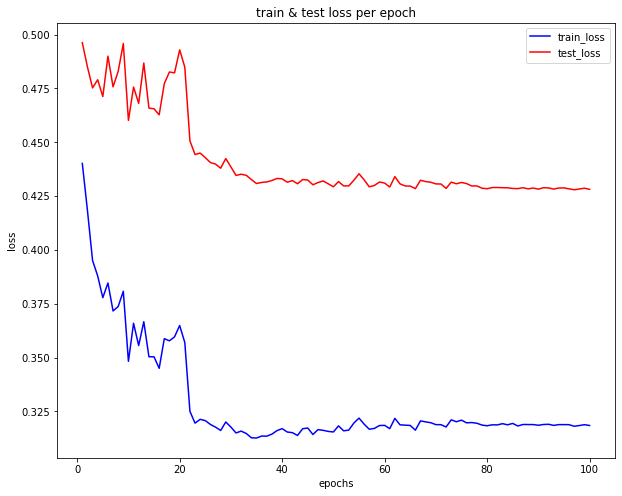

In [18]:
plt.figure(figsize=(10,8))

plt.plot(range(1, 101), train_loss, 'b-', label='train_loss')
plt.plot(range(1, 101), test_loss, 'r-', label='test_loss')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('train & test loss per epoch')
plt.legend()

plt.show()

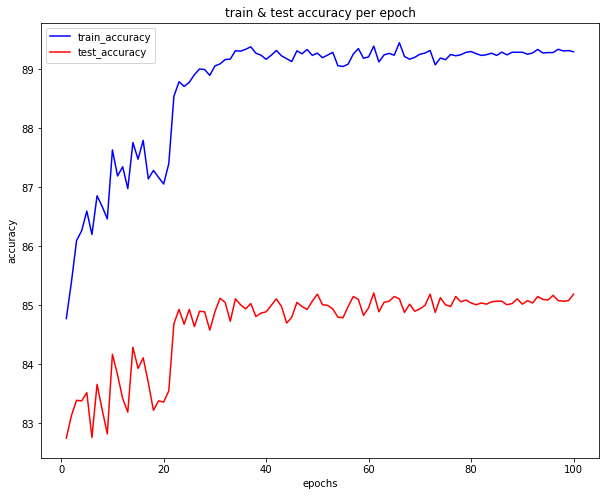

In [19]:
plt.figure(figsize=(10,8))

plt.plot(range(1, 101), train_accuracy, 'b-', label='train_accuracy')
plt.plot(range(1, 101), test_accuracy, 'r-', label='test_accuracy')

plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('train & test accuracy per epoch')
plt.legend()

plt.show()

In [20]:
print(f'Best epoch: {best_epoch}')
print(f'Train: accuracy: {best_train_accuracy:>0.1f}%, avg loss: {best_train_loss:>8f}')
print(f'Test: accuracy: {best_test_accuracy:>0.1f}%, avg loss: {best_test_loss:>8f}')

Best epoch: 61
Train: accuracy: 89.4%, avg loss: 0.317020
Test: accuracy: 85.2%, avg loss: 0.429216


## 5.4 Model metrics

In [21]:
print(f'Train:\n{classification_report(best_train_y, best_train_pred, target_names=target_names)}')
print(f'Test:\n{classification_report(best_test_y, best_test_pred, target_names=target_names)}')

Train:
              precision    recall  f1-score   support

    airplane       0.91      0.93      0.92      5000
  automobile       0.94      0.96      0.95      5000
        bird       0.90      0.82      0.86      5000
         cat       0.81      0.80      0.80      5000
        deer       0.83      0.88      0.85      5000
         dog       0.88      0.83      0.85      5000
        frog       0.88      0.93      0.90      5000
       horse       0.91      0.90      0.91      5000
        ship       0.94      0.95      0.95      5000
       truck       0.95      0.94      0.94      5000

    accuracy                           0.89     50000
   macro avg       0.89      0.89      0.89     50000
weighted avg       0.89      0.89      0.89     50000

Test:
              precision    recall  f1-score   support

    airplane       0.87      0.88      0.88      1000
  automobile       0.90      0.93      0.91      1000
        bird       0.87      0.77      0.81      1000
         ca

<AxesSubplot:>

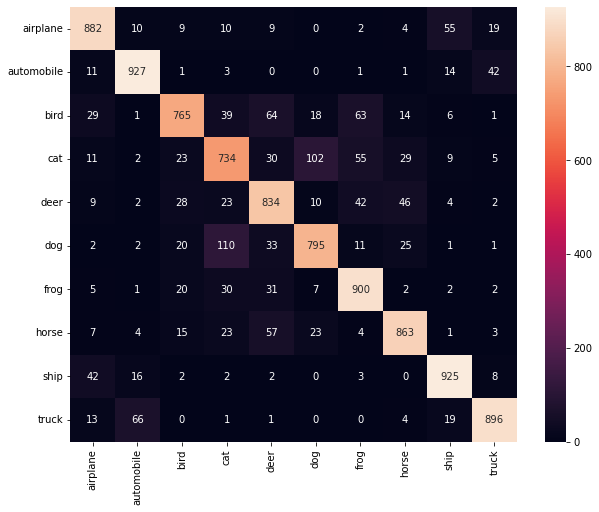

In [22]:
cm = confusion_matrix(best_test_y, best_test_pred)
sns.heatmap(cm, annot=True, fmt='', xticklabels=target_names, yticklabels=target_names, ax=plt.subplots(figsize=(10,8))[1])

## 5.5 Save model

In [23]:
torch.save(best_model_state_dict, '../saved-model/vgg16-weights.pth')